# Aprendizaje Automático

## Práctica 6: Naïve Bayes y clasificación de SPAM

En esta práctica vamos a implementar el clasificador Naïve Bayes desde cero. Antes de ello, comenzaremos utilizando una de las versiones de Naive Bayes que viene con scikit-learn para ver sus resultados. Después, lo implementaremos nosotros mismos para comprender mejor su funcionamiento. Finalmente, desarrollaremos un sistema de detección de Spam utilizando este clasificador y el modelo Bag-of-Words que explicaremos más adelante.

## Índice de la práctica

- [Lectura de datos](#Lectura-de-datos)
- [Naïve Bayes con Scikit-learn](#naivebayes)
- [Implementación de Naïve Bayes](#impnaivebayes)
- [Detección de Spam con Naïve Bayes (versión Multinomial)](#spam)
- [Parte opcional](#Parte-opcional)



Comenzamos la práctica importando los paquetes necesarios. Como siempre, usaremos NumPy, Matplotlib y Scikit-learn. 

In [2]:
import dataset as ds
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn import metrics


# Helper function to test the correctness of the solutions
def test_nb(var, val, msg=""):
    if var == val:
        print("✔️ Test passed.")
    else:
        print("❌ Test failed. " + msg)
        raise AssertionError(msg)


%matplotlib inline

## Lectura de datos

Para comenzar, vamos a hacer la lectura de algunos de los datasets con los que vamos a trabajar. Vamos a utilizar cinco conjuntos de datos diferentes:
* **Banana** es un dataset artificial con dos clases y dos atributos reales. Tiene alrededor de 5000 instancias por lo que las ejecuciones serán algo más lentas con él. El dataset resulta interesante porque nos permita estudiar de manera simple y visual el comportamiento de los modelos de selección de instancias. [Más información](http://sci2s.ugr.es/keel/dataset.php?cod=182)

* **Iris** es un dataset de un problema de clasificación en el que se deben distinguir tres tipos de plantas iris según las cuatro características reales establecidas. Para poder trabajar visualmente con dicho dataset, en esta práctica utilizaremos una modificación del mismo en el que utilizaremos únicamente las dos últimas características. El dataset ya está transformado para tal fin. [Más información](http://archive.ics.uci.edu/ml/datasets/Iris)

* **Australian** consiste en decidir si se debe conceder a una persona dada una tarjeta de crédito o no. El conjunto de datos es interesante porque tiene características numéricas (8) y nominales o categóricas (6). [Más información](http://archive.ics.uci.edu/ml/datasets/Statlog+%28Australian+Credit+Approval%29)

* **Crx** consiste en decidir si se debe conceder a una persona dada una tarjeta de crédito o no. El conjunto de datos es interesante porque tiene características numéricas (6) y nominales o categóricas (9). Es una versión extendida del conjunto de datos *Australian*. [Más información](http://archive.ics.uci.edu/ml/datasets/Credit+Approval)

* **Spambase** es un conjunto de datos correspondiente a la clasificación de emails en Spam o No Spam. Para ello cada e-mail viene representado por 57 características numéricas (en su mayoría frecuencias de aparición de palabras). [Más información](http://archive.ics.uci.edu/ml/datasets/Spambase)

Cada conjunto de datos está en formato KEEL. Para leer este tipo de formato os facilitamos un fichero python `dataset.py` que permite leer los ficheros mediante `ds.lectura_datos(ruta_fichero)`. Esta lectura nos devuelve una estructura de Python de la cual nos interesan los siguientes campos:
* `data`: Es la matriz que contiene los ejemplos (tantas filas como ejemplos y columnas como atributos).
* `target`: Es una array que contiene las clases de los ejemplos leídos (tantos elementos como ejemplos).
* `categorical`: Es una lista con tantos elementos como atributos. Cada elemento indica si el atributo correspondiente es categórico o nominal (1) o numérico (0). Esta lista la necesitaremos para implementar Naive Bayes.

Los conjuntos de datos ya vienen particionados en train y test. Por lo que guardaremos un diccionario con los datasets `nombre dataset -> (conjunto train, conjunto test)` para luego simplemente acceder a un conjunto de datos haciendo por ejemplo para iris `train_iris, test_iris = datasets['iris']`.

In [3]:
# Establecemos los nombres de los datasets a utilizar
nombres_datasets = ['banana', 'iris', 'australian', 'crx', 'spambase']

# Inicializamos el diccionario
datasets = {}

# Para cada dataset realizamos las operaciones
for dataset in nombres_datasets:
    # Establecemos la ruta del train y el test
    file_train = 'datasets/' + dataset + '/' + dataset + '-5dobscv-2tra.dat'
    file_test = 'datasets/' + dataset + '/' + dataset + '-5dobscv-2tst.dat'
    # Leemos los datos con ds.lectura Datos
    train, original_train = ds.lectura_datos(file_train)
    test, original_train = ds.lectura_datos(file_test)
    # Finalmente almacenamos el dataset en formato de tupla (train, test)
    datasets[dataset] = (train, test)
    
    print("Ejemplos por clase en " + dataset + ":")
    print(np.bincount(train.target))

Ejemplos por clase en banana:
[2339 1901]
Ejemplos por clase en iris:
[40 40 40]
Ejemplos por clase en australian:
[306 245]
Ejemplos por clase en crx:
[237 285]
Ejemplos por clase en spambase:
[1449 2231]


In [4]:
test_nb(list(np.bincount(datasets['iris'][0].target)), [40, 40, 40], "Iris no está leído correctamente")
test_nb(list(np.bincount(datasets['banana'][0].target)), [2339, 1901], "Banana no está leído correctamente")
test_nb(list(np.bincount(datasets['crx'][0].target)), [237, 285], "Crx no está leído correctamente")
test_nb(list(np.bincount(datasets['spambase'][0].target)), [1449, 2231], "Spambase no está leído correctamente")
test_nb(list(np.bincount(datasets['australian'][0].target)), [306, 245], "Australian no está leído correctamente")

✔️ Test passed.
✔️ Test passed.
✔️ Test passed.
✔️ Test passed.
✔️ Test passed.


## Naïve Bayes con Scikit-learn <a id="naivebayes"></a>

Antes de realizar nuestra propia implementación de Naive Bayes vamos a ver los resultados que nos permite obtener este clasificador con una de las implementaciones existentes en scikit-learn: [Gaussian Naive Bayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB).

Esta versión de Naive Bayes es la que hemos estudiado en clase para datos numéricos, donde estos se modelan mediante una distribución normal. Hay que destacar que scikit-learn implementa cada variante por separado, sin permitir combinar adecuadamente atributos numéricos y categóricos, lo que sí permitirá nuestra implementación. En scikit-learn, para trabajar con atributos nominales deberías utilizar [Categorical Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html#sklearn.naive_bayes.CategoricalNB).

Antes de comenzar a usar el clasificador, vamos a crear una función para poder ver los resultados en los datasets con dos variables de entrada.

### Visualización de las fronteras de decisión Scikit-learn
Utilizaremos esta visualización en los datasets con dos características como banana e iris.

A continuación, te facilitamos una función que permite mostrar gráficamente los resultados obtenidos. Nos permitirá:
1. **Mostrar los ejemplos utilizados en el entrenamiento con la frontera de decisión** que se logra con Naive Bayes..
3. **Mostramos los ejemplos de test sobre las fronteras de decisión del clasificador** observaremos cuáles se fallan a la hora de generalizar a un conjunto de datos no visto en el entrenamiento.

Su implementación sigue la misma estrategia de prácticas anteriores. 

In [6]:
def mostrar_sk(clasificador, X, y, X_test, y_test):
    """
    Esta función muestra las fronteras de decisión del clasificador ya entrenado y los ejemplos en X
    (con el color dependiendo de y). A la izquierda aparecen los resultados en train y a la derecha los resultados en test
    :param clasificador: Clasificador entrenado de scikit-learn
    :param X: Matriz con los ejemplos a mostrar
    :param y: Vector con las salidas de los ejemplos a mostrar
    :return: Nada
    """
    # Creamos los mapas de colores a utilizar
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    # Preparamos los ejemplos de entrada para poder pintar la frontera de decisión
    # Asignamos una clase (color) a cada ejemplo de la malla en [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() * 0.9, X[:, 0].max() * 1.1
    y_min, y_max = X[:, 1].min() * 0.9, X[:, 1].max() * 1.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Clasificamos los puntos utilizando el método predict del clasificador, debes concatenar las xx con las yy
    Z = clasificador.predict(np.c_[xx.ravel(), yy.ravel()])
    # Ponemos el resultado en el formato deseado (shape de xx o yy)
    # Almacena el resultado en Z
    Z = Z.reshape(xx.shape)
    
    # Creamos la figura
    plt.figure(figsize=(17,5.5))

    # Primer plot a la izquierda
    plt.subplot(121)

    # Pintamos la figura de los ejemplos en X (a la izquierda si ya hemos pintado la primera)
    # Pintamos las fronteras
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')
    # Pintamos los puntos
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    # Asignamos el título
    plt.title("Ejemplos de Train")
    # Establecemos los límites
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Pintamos la figura de los ejemplos en X_test a la derecha
    plt.subplot(122)

    # Pintamos las fronteras
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')
    # Pintamos los puntos de test
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold)
    # Asignamos el título
    plt.title("Ejemplos de Test")
    # Establecemos los límites
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    plt.suptitle('Clasificador: Naive Bayes', fontsize=16)
    # Mostramos la figura
    plt.show()
    return

### Gaussian Naive Bayes

Vamos ahora a ver cómo funciona el modelo de Gaussian Naive Bayes que tiene implementado scikit-learn. Como en los métodos de scikit-learn que hemos visto anteriormente, lo único que debemos hacer es utilizar `fit` para entrenar el modelo con los ejemplos (`train.data` y `train.target`) y predecir los nuevos resultados con `predict`. Recordar que para obtener el porcentaje de acierto puedes seguir usando las métricas de scikit y más concretamente la métrica de `accuracy_score` (ver [Metrics en scikit](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)).

Dataset banana
Resultados sin pre-procesar con Naïve Bayes
Precisión en train: 0.6141509433962264
Precisión en test: 0.6141509433962264


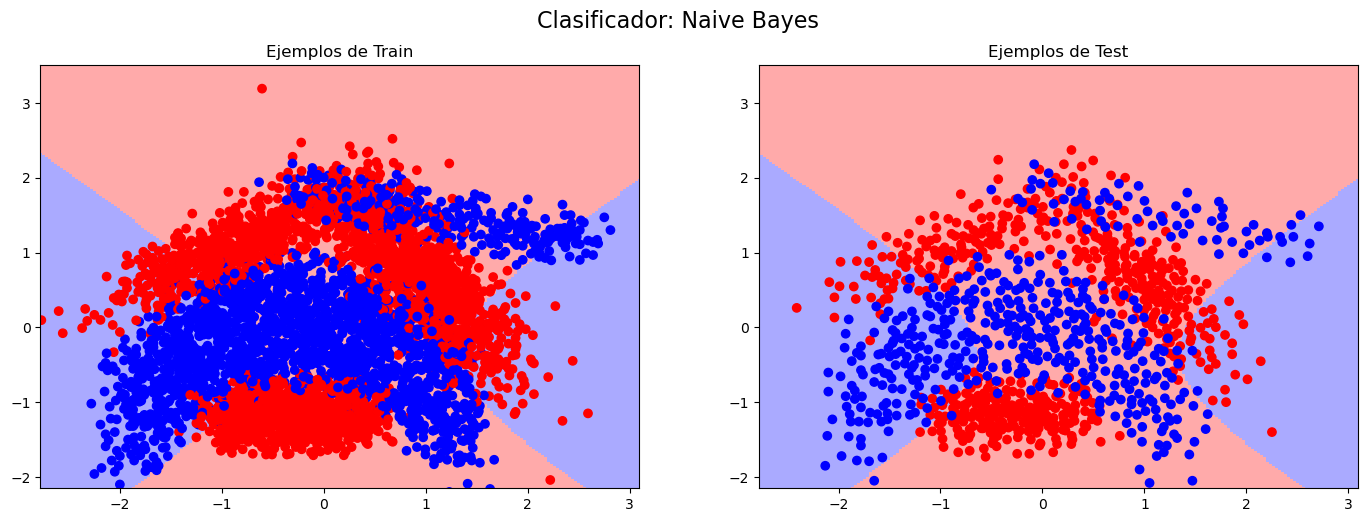

Dataset iris
Resultados sin pre-procesar con Naïve Bayes
Precisión en train: 0.9583333333333334
Precisión en test: 0.9666666666666667


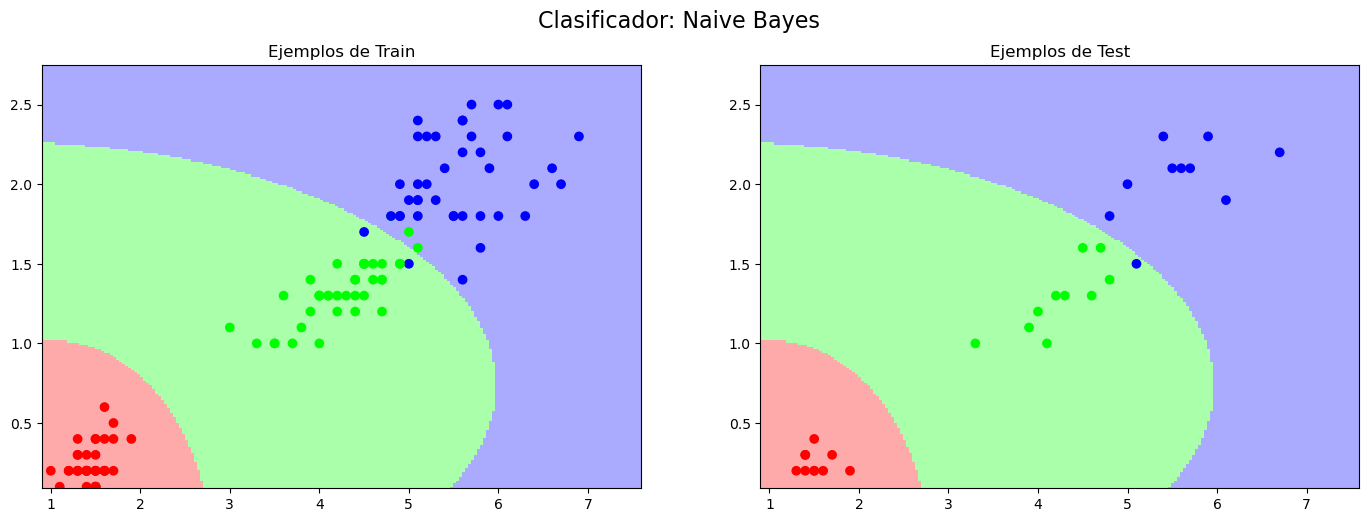

Dataset australian
Resultados sin pre-procesar con Naïve Bayes
Precisión en train: 0.8058076225045372
Precisión en test: 0.7913669064748201
Dataset crx
Resultados sin pre-procesar con Naïve Bayes
Precisión en train: 0.7950191570881227
Precisión en test: 0.7480916030534351
Dataset spambase
Resultados sin pre-procesar con Naïve Bayes
Precisión en train: 0.8236413043478261
Precisión en test: 0.8047982551799345


In [7]:
# acc se usa para los tests
acc = {}

# Creamos el clasificador Naive Bayes con naive_bayes.GaussianNB
from sklearn import naive_bayes

nb = naive_bayes.GaussianNB()

# Evaluamos cada dataset
for dataset in nombres_datasets:
    # Obtenemos los conjuntos de train y test del dataset
    # (train, test) = ...
    (train, test) = datasets[dataset]
    # Entrenamos el clasificador NB con train.data y train.target (que serían nuestra X e y, respectivamente)
    nb.fit(train.data, train.target)
    # Obtenemos las salidas para las instancias de train utilizando predict (guardar en preds_train)
    preds_train = nb.predict(train.data)
    # Obtenemos la precisión en train mediante metrics.accuracy_score
    acc_train = metrics.accuracy_score(preds_train, train.target)
    # Obtenemos las salidas para test mediante predict (guardar en preds_test)
    preds_test = nb.predict(test.data)
    # Obtenemos la precisión en test mediante metrics.accuracy_score (guardar en acc_test)
    acc_test = metrics.accuracy_score(preds_test, test.target)

    # Imprimimos los resultados obtenidos
    print("Dataset " + dataset)
    print("Resultados sin pre-procesar con Naïve Bayes")
    print("Precisión en train: {}".format(acc_train))
    print("Precisión en test: {}".format(acc_test))

    # A continuación mostramos las fronteras de decisión que obtenemos con los conjuntos de train y cómo quedan los
    # ejemplos el conjunto de test en base a dichas fronteras
    if train.data.shape[1] == 2:
        mostrar_sk(nb, train.data, train.target, test.data, test.target)

    # Esto se usa para los tests
    acc[dataset] = (acc_train, acc_test)

In [8]:
tests = {'iris': (0.9583, 0.9667), 'crx': (0.7950, 0.7481), 'australian':(0.8058, 0.7914), 'spambase': (0.8236, 0.8048), 'banana': (0.6142, 0.6142)}
for dataset in nombres_datasets:
    test_nb(round(acc[dataset][0], 4), tests[dataset][0], "Precisión en train incorrecta para " + dataset)
    test_nb(round(acc[dataset][1], 4), tests[dataset][1], "Precisión en test incorrecta para " + dataset)

✔️ Test passed.
✔️ Test passed.
✔️ Test passed.
✔️ Test passed.
✔️ Test passed.
✔️ Test passed.
✔️ Test passed.
✔️ Test passed.
✔️ Test passed.
✔️ Test passed.


## Implementación de Naïve Bayes <a id="impnaivebayes"></a>
Ahora nos vamos a centrar en implementar el clasificador Naive Bayes desde 0, considerando que puede haber tanto atributos nominales como numéricos.

Para ello, vamos a implementar dos funciones:
1. `fit_naive_bayes`: debe crear el modelo, es decir, establecer los parámetros de Naive Bayes que son: las probabilidades a priori de las clases $P(c_j)$, para los atributos ($i$) numéricos, su media $\mu_{i,c_j}$ y desviación estándar $\sigma_{i,c_j}$ por clase (a partir del cual podremos calcular $P(x_i|c_j)$) y para los atributos nominales ($i$), el porcentaje de ocurrencia de cada valor en cada clase ($P(x_i|c_j)$). Todo esto lo vamos a almacenar en un diccionario tal y como explicamos a continuación. Aplicaremos para los atributos nominales el suavizado de laplace con $m=1$, es decir:

$$P(x_i|c_j) = \frac{n_{x_i \wedge c_j} + 1}{n_{c_j}+ n_v} \text{    donde $n_v$ es el número de valores que puede tomar el atributo $i$} $$

2. `predict_naive_bayes`: Deberá utilizar el modelo aprendido con `fit_naive_bayes` para predecir la clase de los ejemplos de entrenada aplicando la regla de Bayes. Recuerda que para evitar posibles underflows (produtos entre valores muy pequeños) utilizaremos la suma de los logaritmos de las probabilidades:
$$ clase = \arg \underset{c_j\in C}{\max} log(P(c_j)) + \sum_{i=1}^n log(P(x_i|c_j)) $$
  donde los valores de $P(x_i|c_j)$ los obtendremos directamente de los porcentajes obtenidos en el caso de los nominales y a partir de la probabilidad dada por estimación dada por la distribución gaussiana de la siguiente forma: 

$$P(x_i|c_j) = \frac{1}{\sqrt{2\cdot\pi}\cdot \sigma_{i,c_j}}\cdot e^{-\frac{(x_i -\mu_{i,c_j})^2}{2\cdot \sigma_{i,c_j}^2}} $$


El modelo lo vamos a almacenar en un diccionario de la siguiente forma:
* `modelo['n_clases']` almacenará el número de clases del problema para luego facilitar la clasifiacción.
* Para cada clase `clase = {0, 1, ..., n_clases}`, guardaremos su probabilidad de ocurrencia $P(clase)$ en `modelo[clase]`.
* Para cada clase y cada atributo almacenaremos en `modelo[(clase, atributo)]` los datos necesarios para calcular $P(x_i|c_j)$ según si el atributo es numérico o nominal:
    * Numérico: `modelo[(clase, atributo)] = (media, desviación)`, es decir, guardamos una tupla donde el primer elemento es la media y el segundo la desviación típica.
    * Nominal/categórico: `modelo[(clase, atributo)] = np.array([Probabilidades])`, es decir, guardamos un array con la probabilidad de ocurrencia de cada valor categórico (los valores van siempre de 0 a $n_v-1$), por tanto, el array tendrá $n_v$ elementos (tantos como valores pueda tomar el atributo.

In [24]:
def fit_naive_bayes(X, y, categorical):
    """ase
    Esta función debe aprender un modelo Naive Bayes. El algoritmo es el siguiente:
        1. Para cada clase estimamos su probabilidad a priori
            - Para cada atributo estimamos sus parámetros para la clase
                * Si es nominal: probabilidad de ocurrencia de los valores dada la clase
                * Si es real: media y desviación estándar de los ejemplos de la clase
    :param X: Matriz con los ejemplos de entrenamiento (tantas filas como ejemplos y columnas como atributos)
    :param y: Vector con las salidas reales de los ejemplos de entrenamiento
    :param categorical: Lista que indica si el atributo i es categórico/nominal o no lo es (es numérico)
    :return: Modelo Naive Bayes en forma de diccionario
    """
    # Obtenemos el número de clases con np.unique (valores únicos en y)
    # n_clases = ...
    n_clases = len(np.unique(y))
    m = 1
    # Obtenemos el número de atributos
    n_atributos = X[0].size

    print('Ejemplos en train: {}'.format(X.shape[0]))
    print('Características totales: {}, número de nominales: {}'.format(len(categorical), np.sum(categorical)))
    print('Número de clases: {}'.format(n_clases))
    
    # Inicializamos el modelo
    modelo = {}
    # Para cada clase....
    for clase in range(0, n_clases): 
        # Obtenemos los ejemplos de la clase como una máscara con un 1 en los ejemplos de la clase y un 0 en los que no lo son
        n_cj = np.where(y==clase, 1, 0).sum()
        # Calculamos la probabilidad a priori de la clase
        modelo[clase] = n_cj/y.size

        # Para cada atributo
        for j in range(0, n_atributos):
            # Si es nominal... 
            # NOTA: Para obtener el número de valores en el atributo busca el máximo valor y súmale 1,
            # el unique no nos asegura el resultado correcto
            if categorical[j]: # Nominales
                n_v = int(X[:,j].max()+1)
                # Calcular conteo.
                probabilidades = []
                for i in range(n_v):
                    n_xv_cj = np.where((y==clase) & (X[:,j] == i), 1, 0).sum()
                    probabilidades.append((n_xv_cj + m) / (n_cj + m*n_v))
                modelo[(clase, j)] = np.array(probabilidades)
            # Si es real...
            else: # Reales
                media = np.nanmean(np.where((y==clase), (X[:,j]), np.nan))
                desviacion = np.nanstd(np.where((y==clase), (X[:,j]), np.nan))
                modelo[(clase, j)] = (media, desviacion)

    # Para terminar almacena en el modelo el número de clases
    modelo['n_clases'] = n_clases
    return modelo


Comprobamos si el modelo obtenido es correcto.

In [25]:
train, test = datasets['australian']
modelo = fit_naive_bayes(train.data, train.target, train.categorical)
#for el in modelo:
#    print(el)
test_nb(modelo['n_clases'], 2, 'Modelo[n_clases] incorrecto')
test_nb(round(modelo[0],4),0.5554, 'Probabilidades a priori incorrectas')
test_nb(round(modelo[(1, 4)][0],4),8.9347, 'Medias incorrectas')
test_nb(round(modelo[(1, 4)][1],4),3.3399, 'Desviaciones estándar incorrectas')
test_nb(list(np.round(modelo[(1, 11)], 4)), [0.0444, 0.9395, 0.0161], 'Probabilidades condicionales incorrectas')
modelo

Ejemplos en train: 551
Características totales: 14, número de nominales: 6
Número de clases: 2
✔️ Test passed.
✔️ Test passed.
✔️ Test passed.
✔️ Test passed.
✔️ Test passed.


{0: 0.5553539019963702,
 (0, 0): array([0.34090909, 0.65909091]),
 (0, 1): (2585.483660130719, 1408.5217166247728),
 (0, 2): (1089.1274509803923, 2838.9250128973617),
 (0, 3): array([0.3171521 , 0.67961165, 0.00323625]),
 (0, 4): (6.349673202614379, 3.4468821600440034),
 (0, 5): (4.26797385620915, 1.8786956118357443),
 (0, 6): (245.1045751633987, 940.6379921102965),
 (0, 7): array([0.78246753, 0.21753247]),
 (0, 8): array([0.76298701, 0.23701299]),
 (0, 9): (0.6862745098039216, 2.012933956737491),
 (0, 10): array([0.57467532, 0.42532468]),
 (0, 11): array([0.11003236, 0.87702265, 0.01294498]),
 (0, 12): (204.6078431372549, 188.9207474772797),
 (0, 13): (199.04575163398692, 674.7934841659344),
 1: 0.44464609800362975,
 (1, 0): array([0.31578947, 0.68421053]),
 (1, 1): (2857.45306122449, 1705.2561920279934),
 (1, 2): (1211.126530612245, 3013.3743409480144),
 (1, 3): array([0.15322581, 0.83870968, 0.00806452]),
 (1, 4): (8.93469387755102, 3.339898019976069),
 (1, 5): (5.220408163265306, 1

Una vez tengamos el modelo correcto, implementamos la función para clasificar. Recuerda:

Para evitar posibles underflows (produtos entre valores muy pequeños) utilizaremos la suma de los logaritmos de las probabilidades:
$$ clase = \arg \underset{c_j\in C}{\max} log(P(c_j)) + \sum_{i=1}^n log(P(x_i|c_j)) $$
  donde los valores de $P(x_i|c_j)$ los obtendremos directamente de los porcentajes obtenidos en el caso de los nominales y a partir de la probabilidad dada por estimación dada por la distribución gaussiana de la siguiente forma: 

$$P(x_i|c_j) = \frac{1}{\sqrt{2\cdot\pi}\cdot \sigma_{i,c_j}}\cdot \exp\left({-\frac{(x_i -\mu_{i,c_j})^2}{2\cdot \sigma_{i,c_j}^2}}\right) $$

donde $exp(x)$ corresponde a $e^x$.



In [26]:
def predict_naive_bayes(modelo, X, categorical):
    """
    Esta función debe utilizar el modelo de Naive Bayes aprendido para predecir la clase de los ejemplos en X
    :param modelo: Modelo Naive Bayes
    :param X: Matriz con los ejemplos de a clasificar (tantas filas como ejemplos y columnas como atributos)
    :param categorical: Lista que indica si el atributo i es categórico/nominal o no lo es (es numérico)
    :return: salida para los ejemplos de entrada
    """   
    # Recuperamos el número de clases (n_clases) y atributos (n_atributos)
    n_clases = modelo['n_clases']
    n_atributos = len(categorical)
    # Inicializamos el vector de salidas (utiliza el nombre salidas)
    salidas = np.zeros(X.shape[0])
    # Para cada ejemplo...
    for i in range(0, X.shape[0]):
        # Inicializamos las probabilidades de cada clase a 0
        suma = np.zeros(n_clases)
        # Para cada clase... calculamos su probabilidad
        for clase in range(0, n_clases):
            # Para cada atributo... vamos sumando las probabilidades a la clase correspondiente dependiendo de si es nominal o categórico
            for j in range(n_atributos):
                if categorical[j]:
                    suma[clase] += np.log(modelo[(clase, j)][int(X[i,j])])
                else:
                    u = modelo[(clase, j)][0]
                    std = modelo[(clase, j)][1]
                    prob = np.e**(-(X[i,j]-u)**2/(2*(std**2))) / (np.sqrt(2*np.pi) * std)
                    suma[clase] += np.log(prob)
            # También sumamos la probabilidad a priori de la clase
            suma[clase] += np.log(modelo[clase])
        # Predecimos la clase para el ejemplo i aquella con mayor probabilidad a posteriori (MAP)
        salidas[i] = np.argmax(suma)
    return salidas

Hagamos una primera prueba con el dataset anterior.

In [27]:
train, test = datasets['australian']
pred = predict_naive_bayes(modelo, test.data[:5], train.categorical)
test_nb(pred.tolist(), [0., 0., 0., 1., 0.], "predict_naive_bayes no funciona correctamente")

✔️ Test passed.


Si el test anterior ha funcionado, ya podemos pasar a ver la predicción con dos problemas muy simples ya vistos con la regresión logística (en este caso solo probaremos los atributos reales). Para ayudarte a visualizarlo, te proveemos de una función de visualización.

### Visualización de las fronteras de decisión de nuestro Naive Bayes
Al igual que hemos hecho con scikit-learn, queremos visualizar las fronteras de decisión de nuestro Naive Bayes. Para ello, vamos a modificar la función vista anteriormente pero con unos pequeños cambios:
1. Ahora el modelo que se recibe es el modelo aprendido con `fit_naive_bayes`
2. Por tanto, a la hora de realizar la predicción debes utilizar `predict_naive_bayes` (recuerda que en este caso debes pasarle la variable categorical)
3. El resto del código es el mismo!!

Repasa la función que ya está preparada para funcionar.

In [29]:
def mostrar(modelo, X, y, X_test, y_test, categorical):
    """
    Esta función muestra las fronteras de decisión del clasificador Naive Bayes ya entrenado y los ejemplos en X
    (con el color dependiendo de y). A la izquierda aparecen los resultados en train y a la derecha los resultados en test
    :param clasificador: Clasificador entrenado con fit_naive_bayes
    :param X: Matriz con los ejemplos a mostrar
    :param y: Vector con las salidas de los ejemplos a mostrar
    :param categorical: Lista que indica si el atributo i es categórico/nominal o no lo es (es numérico)
    :return: Nada
    """
    # Creamos los mapas de colores a utilizar
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    # Preparamos los ejemplos de entrada para poder pintar la frontera de decisión
    # Asignamos una clase (color) a cada ejemplo de la malla en [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() * 0.9, X[:, 0].max() * 1.1
    y_min, y_max = X[:, 1].min() * 0.9, X[:, 1].max() * 1.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    # Clasificamos los puntos
    Z = predict_naive_bayes(modelo, np.c_[xx.ravel(), yy.ravel()], categorical)
    # Ponemos el resultado en el formato deseado
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(17,5.5))

    plt.subplot(121)

    # Pintamos la figura de los ejemplos en X (a la izquierda si ya hemos pintado la primera)
    # Pintamos las fronteras
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')
    # Pintamos los puntos
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    # Asignamos el título
    plt.title("Ejemplos de Train")
    # Establecemos los límites
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Pintamos la figura de los ejemplos en X_test (a la izquierda si ya hemos pintado la primera)
    plt.subplot(122)

    # Pintamos las fronteras
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')
    # Pintamos los puntos de test
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold)
    # Asignamos el título
    plt.title("Ejemplos de Test")
    # Establecemos los límites
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    plt.suptitle('Clasificador: Naive Bayes', fontsize=16)
    # Mostramos la figura
    plt.show()
    return

Ahora ya puedes utilizar nuestro modelo y comprobar su resultado en los datasets indicados.

> **Nota:** No te preocupes por el warning de la división por cero, podrías controlarlo en el caso de los numéricos cuando se da que la probabilidad es cero.

Ejemplos en train: 4240
Características totales: 2, número de nominales: 0
Número de clases: 2
Dataset banana
Resultados con Naïve Bayes
Precisión en train: 0.6141509433962264
Precisión en test: 0.6141509433962264


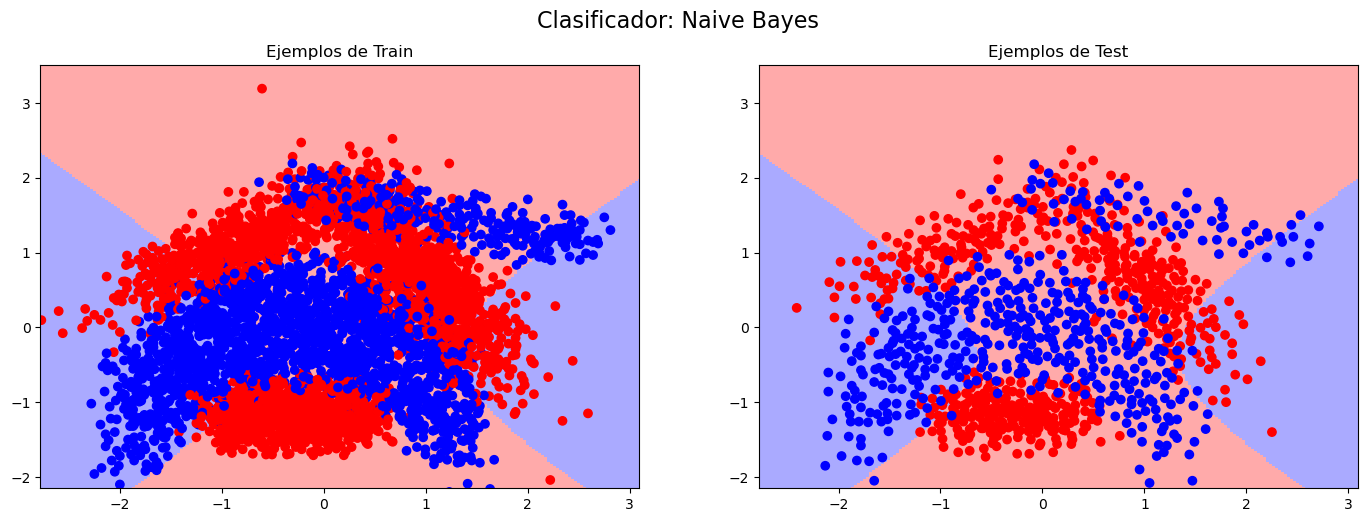

Ejemplos en train: 120
Características totales: 2, número de nominales: 0
Número de clases: 3
Dataset iris
Resultados con Naïve Bayes
Precisión en train: 0.9583333333333334
Precisión en test: 0.9666666666666667


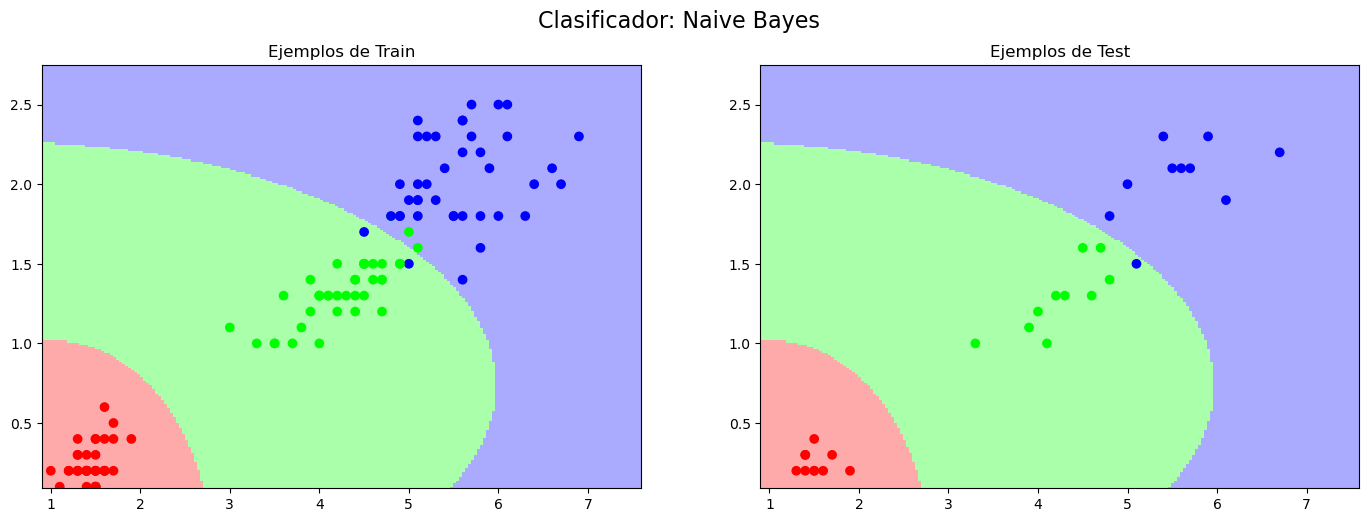

Ejemplos en train: 551
Características totales: 14, número de nominales: 6
Número de clases: 2
Dataset australian
Resultados con Naïve Bayes
Precisión en train: 0.7858439201451906
Precisión en test: 0.7769784172661871
Ejemplos en train: 522
Características totales: 15, número de nominales: 9
Número de clases: 2
Dataset crx
Resultados con Naïve Bayes
Precisión en train: 0.7950191570881227
Precisión en test: 0.7404580152671756
Ejemplos en train: 3680
Características totales: 57, número de nominales: 0
Número de clases: 2


/var/folders/x1/zlr91hyj1kb9jx7yvlg1rcn80000gn/T/ipykernel_99541/1591915704.py:28: RuntimeWarning: divide by zero encountered in log
  suma[clase] += np.log(prob)
/var/folders/x1/zlr91hyj1kb9jx7yvlg1rcn80000gn/T/ipykernel_99541/1591915704.py:28: RuntimeWarning: divide by zero encountered in log
  suma[clase] += np.log(prob)
/var/folders/x1/zlr91hyj1kb9jx7yvlg1rcn80000gn/T/ipykernel_99541/1591915704.py:28: RuntimeWarning: divide by zero encountered in log
  suma[clase] += np.log(prob)
/var/folders/x1/zlr91hyj1kb9jx7yvlg1rcn80000gn/T/ipykernel_99541/1591915704.py:28: RuntimeWarning: divide by zero encountered in log
  suma[clase] += np.log(prob)
/var/folders/x1/zlr91hyj1kb9jx7yvlg1rcn80000gn/T/ipykernel_99541/1591915704.py:28: RuntimeWarning: divide by zero encountered in log
  suma[clase] += np.log(prob)


Dataset spambase
Resultados con Naïve Bayes
Precisión en train: 0.8220108695652174
Precisión en test: 0.7982551799345693


/var/folders/x1/zlr91hyj1kb9jx7yvlg1rcn80000gn/T/ipykernel_99541/1591915704.py:28: RuntimeWarning: divide by zero encountered in log
  suma[clase] += np.log(prob)


In [30]:
# Para los tests
acc = {}

# Evaluamos cada dataset
for dataset in nombres_datasets:
    # Obtenemos los conjuntos de train y test del dataset
    (train, test) = datasets[dataset]
    # Entrenamos nuestro modelo de Naive bayes
    modelo = fit_naive_bayes(train.data, train.target, train.categorical)
    # Obtenemos las salidas para las instancias de train utilizando nuestro modelo
    preds_train = predict_naive_bayes(modelo, train.data, train.categorical)
    # Obtenemos la precisión en train mediante metrics.accuracy_score
    acc_train = metrics.accuracy_score(preds_train, train.target)
    # Obtenemos las salidas para test mediante predict_naive_bayes
    prediction_test = predict_naive_bayes(modelo, test.data, train.categorical)
    # Obtenemos la precisión en test mediante metrics.accuracy_score
    acc_test = metrics.accuracy_score(prediction_test, test.target)
    
    # Almacena el accuracy en train y test como una tupla en el diccionario acc
    acc[dataset] = (acc_train, acc_test)
    
    # Imprimimos los resultados obtenidos
    print("Dataset " + dataset)
    print("Resultados con Naïve Bayes")
    print("Precisión en train: {}".format(acc_train))
    print("Precisión en test: {}".format(acc_test))
    
    # A continuación mostramos las fronteras de decisión que obtenemos con los conjuntos de train y cómo quedan los
    # ejemplos el conjunto de test en base a dichas fronteras
    if (train.data.shape[1] == 2):
        mostrar(modelo, train.data, train.target, test.data, test.target, train.categorical)

In [31]:
# Estos es para el test
tests = {'iris': (0.9583, 0.9667), 'crx': (0.7950, 0.7405), 'australian':(0.7858, 0.7770), 'spambase': (0.8220, 0.7983), 'banana': (0.6142, 0.6142)}
for dataset in nombres_datasets:
    test_nb(round(acc[dataset][0], 4), tests[dataset][0], "Precisión en train incorrecta para " + dataset)
    test_nb(round(acc[dataset][1], 4), tests[dataset][1], "Precisión en test incorrecta para " + dataset)

✔️ Test passed.
✔️ Test passed.
✔️ Test passed.
✔️ Test passed.
✔️ Test passed.
✔️ Test passed.
✔️ Test passed.
✔️ Test passed.
✔️ Test passed.
✔️ Test passed.


## Detección de Spam con Naïve Bayes (versión Multinomial)
En este apartado vamos a resolver un problema más específico y desde cero con Naive Bayes: La detección de Spam.

Sin embargo, vamos a ver que para ello debemos hacer alguna modificación al algoritmo.

### Lectura de datos

Tenemos dentro de la carpeta `spam` que está dentro de la carpeta `datasets` otras cuatro carpetas con los conjuntos de train y test separados según su clase: spam, nonspam.

Vamos a implementar una función `leer_carpeta` que nos lea todos los emails en una carpeta y los meta en una lista de emails.

In [32]:
import glob

def leer_carpeta(carpeta):
    """
    Lee una carpeta de emails
    :param carpeta: nombre de la carpeta a leer
    :return: lista de emails en la carpeta
    """
    # Establecemos la ruta completa
    path = 'datasets/spam/' + carpeta + '/*.txt'   
    # Obtenemos la lista de ficheros en la carpeta
    files = glob.glob(path)   
    textos = []
    # Para cada fichero, lo leemos y lo añadimos a la lista
    for name in files: 
        with open(name) as f: 
            textos.append(f.read())

    print("Leidos ", len(textos), " emails en ", path)
    
    return textos

Vamos a comprobar la función de lectura.

In [33]:
# Utilizamos la función leer carpeta para leer las carpetas: nonspam-train, nonspam-test, spam-train y spam-test
nonspam_train = leer_carpeta('nonspam-train')
nonspam_test = leer_carpeta('nonspam-test')
spam_train = leer_carpeta('spam-train')
spam_test = leer_carpeta('spam-test')

# Creamos la lista de emails de entrenamiento como la suma de las dos listas cone ejemplos de entrenamiento
textos_train = nonspam_train + spam_train
# Creamos y_train como la concatenación de un vector de ceros con el tamaño de nonspam_train y otro de unos con el tamaño de spam_train
y_train = np.hstack((np.zeros((len(nonspam_train))), np.ones((len(spam_train)))))

# Crea la lista de emails de teste como la suma de las dos listas con ejemplos de test
# textos_test = ...
textos_test = nonspam_test + spam_test
# Crea y_test como la concatenación de un vector de ceros con el tamaño de nonspam_test y otro de unos con el tamaño de spam_test
# y_test = ...
y_test = np.hstack((np.zeros((len(nonspam_test))), np.ones((len(spam_test)))))

print("Ejemplo de un email: ", textos_train[10])

Leidos  350  emails en  datasets/spam/nonspam-train/*.txt
Leidos  130  emails en  datasets/spam/nonspam-test/*.txt
Leidos  350  emails en  datasets/spam/spam-train/*.txt
Leidos  130  emails en  datasets/spam/spam-test/*.txt
Ejemplo de un email:  computational linguistics altavista refine option colleague mine tell refine option offer altavista search engine http www altavista digital com nutshell refine option returns list synonym notion relate word query indeed extremely sensible response perversely perhap try french vin else keyword bingo return etait etre annee meme apr etaient dernier egalement particulierement different possibilite qualite vin vin vignoble vigne crus vign vigneron vigneron etc far satisfactory eau pain return similar nonsense feature etaient etre egalement et alium prominent position fact altavista refine seem decidedly adverse foodstuff french fruit poisson sandwich fail equally miserably sable mer lac quite surprise italian query wine return sensible synonym vin

In [34]:
test_nb(len(textos_train), 700, 'Número de emails en train incorrectos')
test_nb(len(textos_test), 260, 'Número de emails en test incorrectos')
test_nb(sorted(textos_test)[10][:100], ' thank recent visit one our sponsor webpage invite evaluate brand free internet search engine servic', 'Emails en test incorrectos')
test_nb(sorted(textos_test)[250][:100], 'wealthy please ignore read letter subject ve already learn useful effective network market technique', 'Emails en test incorrectos')
test_nb(sorted(textos_train)[11][:100], ' increase personal prestige money earn power through advance university degree eminent nonaccedit un', 'Emails en train incorrectos')
test_nb(sorted(textos_train)[600][:100], 'submit spam receive message member safemail list wish part listclick here want site found submit is ', 'Emails en train incorrectos')

✔️ Test passed.
✔️ Test passed.
✔️ Test passed.
✔️ Test passed.
✔️ Test passed.
✔️ Test passed.


El siguiente paso consiste en transformar los emails en vectores de características. Podemos hacer esto fácilmente porque los emails que has leído ya han sido procesados mediante los siguientes pasos (los emails provienen de [Ling-spam dataset](http://csmining.org/index.php/ling-spam-datasets.html)):

 1. *Stop word removal:* Se eliminan palabras como  "and," "the," and "of," que son muy comunes en las frases en Inglés y no permiten decidir sin email es spam o no lo es.

2. *Lemmatization:* Palabras que tienen el mismo significado pero final diferente se ajustan para que tengan la misma forma. Por ejemplo, "include", "includes," e "included," todas se representan como "include." Además todas las palabras se pasan a minúsculas.

3. *Removal of non-words:* Se elimina todo lo que no son palabras, números y símbolos de puntuación. Todos los tipos de espacios (tabuladores, nueva línea y espacios) se convierten a un único espacio.

Para obtener el vector de características vamos a usar un método muy simple disponible en scikit-learn: [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer). Este modelo también se conoce en la literatura como Bag of Words.

Este método simplemente crea un vector de características donde cada atributo representa una palabra del diccionario aprendido (el diccionario está formado por la N palabras más repetidas). En la forma en la que lo vamos a usar, cada atributo tomará el valor 1 si la palabra aparece en el email y el 0 si no aparece.

Como siempre utilizamos `fit_tranform` para obtener el conjunto de entrenamiento procesado y luego para el de test aplicamos solo `transform`. En este caso, no nos devuelve directamente una matriz sino otra forma de repsentación, para convertirlo a nuestra forma habitual simplemente utilizaremos el método `toarray()`.

In [35]:
# Importamos el módulo necesario
from sklearn.feature_extraction import text

# Inicializamos CountVectorizer indicando el tamaño del diccionario (max_features)
# Inicialmente usaremos las 250 palabras más repetidas
# Inicializa n_atributos a ese número
n_atributos = 250
# Utiliza la variable inicializada para el parámetro max_features de CountVectorizer
vectorizer = text.CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = n_atributos,    \
                             binary=True) 

# Obtén la nueva representación con fit_transform() hace dos cosas: Primero crea el diccionario
# Después transforma el conjunto de train usando el diccionario
# Guarda la nueva representación en train_data_features

train_data_features = vectorizer.fit_transform(textos_train, y_train)
# Convertimos lo devuelto a un array de número de ejemplos x número de atributos
train_data_features = train_data_features.toarray()

print(train_data_features.shape)
test_nb(train_data_features.shape, (700, 250), 'dimensiones de train_data_features incorrectas')

# Veamos las cinco primeras palabras en el diccionario
vocab = vectorizer.get_feature_names_out()
print(vocab[:5])

# Obtenemos también los ejemplos de test (test_data_features)
test_data_features = vectorizer.transform(textos_test).toarray()

print(test_data_features.shape)
test_nb(test_data_features.shape, (260, 250), 'dimensiones de test_data_features incorrectas')

(700, 250)
✔️ Test passed.
['above' 'abstract' 'accept' 'account' 'add']
(260, 250)
✔️ Test passed.


In [36]:
# En este problema todo son atributos categóricos, por tanto creamos una lista de todo 1's 
# de tantos elementos como número de atributos
categorical = [1]*n_atributos

Vamos a probar primero qué tal funciona el modelo de Naive Bayes que ya tenemos preparado.

In [37]:
# Entrenamos el modelo con los datos disponibles
modelo = fit_naive_bayes(train_data_features, y_train, categorical)

# Obtenemos las salidas para las instancias de train
preds_train = predict_naive_bayes(modelo, train_data_features, categorical)
# Obtenemos la precisión en train mediante metrics.accuracy_score (acc_train)
acc_train = metrics.accuracy_score(preds_train, y_train)
# Obtenemos las salidas para test 
preds_test = predict_naive_bayes(modelo, test_data_features, categorical)
# Obtenemos la precisión en test mediante metrics.accuracy_score (acc_test)
acc_test = metrics.accuracy_score(preds_test, y_test)

# Imprimimos los resultados obtenidos
print("Dataset " + 'spam')
print("Resultados con Naïve Bayes")
print("Precisión en train: {}".format(acc_train))
print("Precisión en test: {}".format(acc_test))

Ejemplos en train: 700
Características totales: 250, número de nominales: 250
Número de clases: 2
Dataset spam
Resultados con Naïve Bayes
Precisión en train: 0.8685714285714285
Precisión en test: 0.7884615384615384


In [38]:
test_nb(round(acc_train, 4), 0.8686, "Precisión en train incorrecta")
test_nb(round(acc_test, 4), 0.7885, "Precisión en test incorrecta")

✔️ Test passed.
✔️ Test passed.


El resultado no es todo lo bueno que nos gustaría. ¿Por qué ocurre esto?

Estamos trabajando con características nominales, pero solo pueden tomar valor 0 o 1 y en muchos casos tendremos valor 0. Reealmente, no queremos modeloar el hecho de que porque una palabra no esté en el email, el email va a ser má probablemente Spam o No Spam. Queremos fijarnos solo en las palabras que aparecen. Es decir, queremos modelar la probabilidad de que siendo un email spam, aparezca la palabra en cuestión (P(palabra|spam)) o lo contrario en el caso de no spam  (P(palabra|no spam)). Pero NO estamos interesado en P(NO palabra|spam) ni en P(NO palabra|No spam).

Y esto es precísmanete lo que tiene en cuenta el modelo de Naive Bayes multinomial que vamos a implementar. Puedes partir delas implementaciones anteriores. En este caso, ya sabemos que todos los atributos van a ser nominales.

Lo que vamos a hacer es, para cada clase y cada atributo calcular la probabilidad de que ocurra la palabra dada la clase (suavizándolo con laplace):
$$P(\text{palabra|clase})=\frac{conteo(\text{palabra y clase})+1}{conteo(\text{palabras en correos clase})+1}$$

Por tanto, nuestro modelo guardará para cada clase y atributo `modelo[(clase, atributo)] = probabilidad`, una única probabilidad, que indica la probabilidad de que esa palabra aparezca en un email de la clase correspondiente.

In [39]:
def fit_multinomial_naive_bayes(X, y):
    """
    Esta función debe aprender un modelo Naive Bayes Multinomial. El algoritmo es el siguiente:
        1. Para cada clase estimamos su probabilidad a priori
            - Para cada atributo estimamos la probabilidad de que la palabra aparezca dada la clase
    :param X: Matriz con los ejemplos de entrenamiento (tantas filas como ejemplos y columnas como atributos)
    :param y: Vector con las salidas reales de los ejemplos de entrenamiento
    :return: Modelo Naive Bayes en forma de diccionario
    """
    # Incializamos el número de clases y atributos
    n_clases = np.unique(y).size
    n_atributos = X.shape[1]
    n = y.size

    print('Ejemplos en train: {}'.format(X.shape[0]))
    print('Características totales: {}, número de nominales: {}'.format(len(categorical), np.sum(categorical)))
    print('Número de clases: {}'.format(n_clases))
    # Inicializamos el modelo
    modelo = {}
    # Para cada clase...
    for clase in range(0, n_clases): 
        # Obtenemos los ejemplos de la clase y calculamos la probabilidad a priori
        n_cj = np.where(y==clase, 1, 0).sum()
        p_cj = n_cj / n
        modelo[clase] = p_cj

        # Para cada atributo
        for atributo in range(n_atributos):
            # Calculamos el conteo
            count_palabra_clase = np.where((y==clase) & (X[:,atributo] == 1), 1, 0).sum()
            count_palabra = X[y==clase].sum()
            
            p_palabra_clase = (count_palabra_clase + 1) / (count_palabra + 1)
            modelo[(clase, atributo)] = p_palabra_clase

    # Para terminar almacenamos en el modelo el número de clases
    modelo['n_clases'] = n_clases
    return modelo


Lógicamente, el modelo de clasificación también cambia. Ahora simplemente para cada clase estimamos la probabilidad a partir de las probabilidades P(palabra|clase) SOLO SI la palabra aparece en el email, en otro caso no se penaliza. Es decir:
1. Para cada clase 
    * suma[clase] = 0
    * Para cada palabra que aparece en el email (valor 1 en el atributo correspondiente)
        * suma[clase] += log(P(palabra|clase))
    * suma[clase] += log(P(clase))
2. Elegir la clase con mayor suma (probabilidad)

In [40]:
def predict_multinomial_naive_bayes(modelo, X):
    """
    Esta función debe utilizar el modelo de Naive Bayes Multinomial aprendido para predecir la clase de los ejemplos en X
    :param modelo: Modelo Naive Bayes
    :param X: Matriz con los ejemplos de a clasificar (tantas filas como ejemplos y columnas como atributos)
    :return: salida para los ejemplos de entrada
    """  
    # Obtenemos el número de clases, atributos e inicializamos las salidas
    n_clases = modelo['n_clases'] 
    n_atributos = X.shape[1]
    salidas = np.zeros(X.shape[0])

    # Para cada ejemplos...
    for i in range(0, X.shape[0]):
        # Incializamos las probabilidades por clase
        suma = np.zeros(n_clases)
        # Para cada clase...
        for clase in range(0, n_clases):
            # Para cada atributo... simplemente sumamos la probabilidad correspondiente en caso de aparición de la palabra
            for atributo in range(n_atributos):
                if X[i, atributo] == 1:
                    suma[clase] += np.log(modelo[(clase, atributo)])
            # Sumamos la probabilidad a priori 
            suma[clase] += np.log(modelo[clase])
        # Elejemos la clase con mayor probabilidad
        salidas[i] = np.argmax(suma)
    return salidas

Comprobemos qué tal funciona nuestro nuevo modelo.

In [41]:
# Entrenamos el modelo con Naive Bayes Multinomial
modelo = fit_multinomial_naive_bayes(train_data_features, y_train)

# Obtenemos las salidas para las instancias de train
preds_train = predict_multinomial_naive_bayes(modelo, train_data_features)
# Obtenemos la precisión en train mediante metrics.accuracy_score (acc_train)
acc_train = metrics.accuracy_score(preds_train, y_train)
# Obtenemos las salidas para test 
preds_test = predict_multinomial_naive_bayes(modelo, test_data_features)
# Obtenemos la precisión en test mediante metrics.accuracy_score (acc_test)
acc_test = metrics.accuracy_score(preds_test, y_test)

# Imprimimos los resultados obtenidos
print("Dataset " + 'spam')
print("Resultados con Naïve Bayes")
print("Precisión en train: {}".format(acc_train))
print("Precisión en test: {}".format(acc_test))

Ejemplos en train: 700
Características totales: 250, número de nominales: 250
Número de clases: 2
Dataset spam
Resultados con Naïve Bayes
Precisión en train: 0.9671428571428572
Precisión en test: 0.9653846153846154


In [42]:
test_nb(round(acc_train, 4), 0.9671, "Precisión en train incorrecta")
test_nb(round(acc_test, 4), 0.9654, "Precisión en test incorrecta")

✔️ Test passed.
✔️ Test passed.


¿Ha mejorado el resultado?

## Detección de Spam con Multinomial Naïve Bayes de Scikit-learn <a id="spam"></a>
El mismo modelo multinomial también está disponible en scikit-learn. Utiliza el [MultinomialNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB) de scikit y comprueba si obtienes el mismo resultado.

In [43]:
from sklearn.naive_bayes import MultinomialNB
# Crea el model
nb = MultinomialNB(alpha=1)

# Lo entrenamos
nb.fit(train_data_features, y_train)
# Obtenemos las salidas para las instancias de train 
preds_train = nb.predict(train_data_features)
# Obtenemos la precisión en train mediante metrics.accuracy_score (acc_train)
acc_train = metrics.accuracy_score(preds_train, y_train)
# Obtenemos las salidas para test 
preds_test = nb.predict(test_data_features)
# Obtenemos la precisión en test mediante metrics.accuracy_score (acc_test)
acc_test = metrics.accuracy_score(preds_test, y_test)

# Imprimimos los resultados obtenidos
print("Dataset " + 'spam')
print("Resultados sin pre-procesar con Naïve Bayes")
print("Precisión en train: {}".format(acc_train))
print("Precisión en test: {}".format(acc_test))

Dataset spam
Resultados sin pre-procesar con Naïve Bayes
Precisión en train: 0.9671428571428572
Precisión en test: 0.9653846153846154


In [44]:
test_nb(round(acc_train, 4), 0.9671, "Precisión en train incorrecta")
test_nb(round(acc_test, 4), 0.9654, "Precisión en test incorrecta")

✔️ Test passed.
✔️ Test passed.


### Conclusiones
En pocas líneas hemos sido capaces de implementar dos modelos Naive Bayes igual de potentes que los disponibles en una herramienta como Scikit-Learn.

## Parte opcional

Los ejercicios anteriores permiten, si se completan perfectamente, alcanzar un 9.5 en esta práctica. Esta última parte se valora 0.5 puntos, permitiendo alcanzar el 10.

### Haz las pruebas necesarias para obtener el mejor valor para el tamaño del diccionario de CountVectorizer
Hasta ahora hemos usado 250 palabras, pero podría ser mejor utilizar más para detectar mejor el Spam. Crea un conjunto de validación a partir del conjunto de train y estima cuál será el mejor valor para este parámetro. ¿Qué resultado obtienes en la clasificación de Spam?

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([('countvec', text.CountVectorizer()), ('multinomial', MultinomialNB())])
pipe = pipe.set_params(countvec__analyzer="word", countvec__tokenizer=None, countvec__preprocessor=None, countvec__stop_words=None, countvec__binary=True, multinomial__alpha=1)

params = {'countvec__max_features': [200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100]}

grid = GridSearchCV(pipe, params)

grid.fit(textos_train, y_train)

preds_train = grid.predict(textos_train)
preds_test = grid.predict(textos_test)
acc_train_gs = metrics.accuracy_score(preds_train, y_train)
acc_test_gs = metrics.accuracy_score(preds_test, y_test)
print(f"Mejor cantidad de palabras {grid.best_params_['countvec__max_features']}")
print(f"Precision en train {round(acc_train_gs, 4)} | diferencia de {round(abs(acc_train_gs - acc_train), 4)} con 250 palabras")
print(f"Precision en test {round(acc_test_gs, 4)} | diferencia de {round(abs(acc_test_gs - acc_test), 4)} con 250 palabras")

Mejor cantidad de palabras 1000
Precision en train 0.9914 | diferencia de 0.0243 con 250 palabras
Precision en test 0.9808 | diferencia de 0.0154 con 250 palabras
